In [1]:
from torch import nn
from torchvision.models import resnet152, resnet101
from torchvision import transforms
import torch
import torch.nn.functional as f
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.utils import make_grid
from typing import Tuple
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pickle import UnpicklingError
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

import zipfile as zf
import shutil
import os

import pandas as pd
import numpy as np

from PIL import Image
from tqdm import tqdm
import scipy.stats
import seaborn as sns
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import spearmanr, linregress
import string
import numpy as np
import matplotlib.pyplot as plt
import collections
from itertools import tee, islice
from sklearn.decomposition import PCA
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from datetime import date
from math import sqrt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR, CosineAnnealingWarmRestarts
import random

In [2]:
def curateData(pth, price_col, date_col, n_steps):
    """Reads the dataset and based on n_steps/lags to consider in the time series, creates input output pairs
    Args:
        pth ([str]): [Path to the csv file]
        price_col ([str]): [The name of column in the dataframe that holds the closing price for the stock]
        date_col ([str]): [The nameo oc column in the dataframe which holds dates values]
        n_steps ([int]): [Number of steps/ lags based on which prediction is made]
    """
    df = pd.read_csv(pth)
    
    has_nan = df.isna().any().any()

    if has_nan:
        print("There are NaN values in the DataFrame.")
    else:
        print("There are no NaN values in the DataFrame.")

    # Create lags for the price column
    for idx in range(n_steps):
        df[f"lag_{idx + 1}"] = df[price_col].shift(periods = (idx + 1))
    
    # Create a dataframe which has only the lags and the date
    new_df = df[[date_col, price_col] + [f"lag_{x + 1}" for x in range(n_steps)]]
    new_df = new_df.iloc[n_steps:-1, :]

    # Get a list of dates for which these inputs and outputs are
    dates = list(new_df[date_col])

    # Create input and output pairs out of this new_df
    ips = []
    ops = []
    for entry in new_df.itertuples():
        ip = entry[-n_steps:][::-1]
        op = entry[-(n_steps + 1)]
        ips.append(ip)
        ops.append(op)

    return (ips, ops, dates)



class stockTickerDataset(Dataset):
    """This class is the dataset class which is used to load data for training the LSTM 
    to forecast timeseries data
    """

    def __init__(self, inputs, outputs):
        """Initialize the class with instance variables
        Args:
            inputs ([list]): [A list of tuples representing input parameters]
            outputs ([list]): [A list of floats for the stock price]
        """
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        """Returns the total number of samples in the dataset
        """
        return len(self.outputs)
    
    def __getitem__(self, idx):
        """Given an index, it retrieves the input and output corresponding to that index and returns the same
        Args:
            idx ([int]): [An integer representing a position in the samples]
        """
        x = torch.FloatTensor(self.inputs[idx])
        y = torch.FloatTensor([self.outputs[idx]])
        
        return (x, y)
    
    
def standardizeData(X, SS = None, train = False):
    """Given a list of input features, standardizes them to bring them onto a homogenous scale
    Args:
        X ([dataframe]): [A dataframe of all the input values]
        SS ([object], optional): [A StandardScaler object that holds mean and std of a standardized dataset]. Defaults to None.
        train (bool, optional): [If False, means validation set to be loaded and SS needs to be passed to scale it]. Defaults to False.
    """
    if train:
        SS = StandardScaler()   
        new_X = SS.fit_transform(X)
        return (new_X, SS)
    else:
        new_X = SS.transform(X)
        return (new_X, None)
    
    
    
def getDL(x, y, params):
    """Given the inputs, labels and dataloader parameters, returns a pytorch dataloader
    Args:
        x ([list]): [inputs list]
        y ([list]): [target variable list]
        params ([dict]): [Parameters pertaining to dataloader eg. batch size]
    """
    training_set = stockTickerDataset(x, y)
    training_generator = DataLoader(training_set, **params)
    return training_generator



def train_val_split(x, y, train_pct):
    """Given the input x and output labels y, splits the dataset into train, validation and test datasets
    Args:
        x ([list]): [A list of all the input sequences]
        y ([list]): [A list of all the outputs (floats)]
        train_pct ([float]): [% of data in the test set]
    """
    # Perform a train test split (It will be sequential here since we're working with time series data)
    N = len(x)
    
    trainX = x[:int(train_pct * N)]
    trainY = y[:int(train_pct * N)]

    valX = x[int(train_pct * N):]
    valY = y[int(train_pct * N):]

    return (trainX, trainY, valX, valY)




inputs, labels, dates = curateData("TimeSeriesForecastingNN-main/data/20MICRONS.csv", "Close", "Date", 1)

print(len(inputs))

batch_size = 4

params = {"batch_size": batch_size,
         "shuffle": False,
         "num_workers": 0}

inputs = inputs[:-2]
labels = labels[:-2]
dates = dates[:-2]


# Perform the train validation split
train_x, train_y, val_x, val_y = train_val_split(inputs, labels, 0.5)

# Standardize the data to bring the inputs on a uniform scale
train_x, SS_ = standardizeData(train_x, train = True)
val_x, _ = standardizeData(val_x, SS_)

val_y = standardizeData(np.array(val_y).reshape(-1, 1), SS_)[0].flatten()

train_y = standardizeData(np.array(train_y).reshape(-1, 1), SS_)[0].flatten()
val_y = val_y[5:]
train_y = train_y[4:]
train_x = train_x[4:]
val_x = val_x[5:]

# Create dataloaders for both training and validation datasets
training_generator = getDL(train_x, train_y, params)
validation_generator = getDL(val_x, val_y, params)

There are no NaN values in the DataFrame.
203


In [3]:
len(val_x)

96

In [4]:
len(train_x)

96

In [5]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(LSTMNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=False)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
        self._initialize_weights()
        
    def forward(self, x, hidden):
        batch_size = x.shape[1]
        # x = x.long()
        #embeds = self.embedding(x)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        #out = out.view(batch_size, -1)
        #out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
          weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden
    
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
                elif isinstance(m, nn.LSTM):
                    for name, param in m.named_parameters():
                        if 'weight_ih' in name:
                            nn.init.xavier_uniform_(param.data)
                        elif 'weight_hh' in name:
                            nn.init.orthogonal_(param.data)
                        elif 'bias' in name:
                            param.data.fill_(0)


In [6]:
vocab_size = 1
output_size = 1
embedding_dim = batch_size
hidden_dim = 512
n_layers = 2

model = LSTMNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
device = torch.device("mps")
model.to(device)

lr=0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 1000
counter = 0
print_every = 10
clip = 5
valid_loss_min = np.Inf

In [7]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('mps')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

In [8]:
force_cudnn_initialization()

In [9]:
model.train()
for i in range(epochs):
    
    for inputs, labels in training_generator:
        counter += 1
        #h = tuple([e.data for e in h])
        h = model.init_hidden(batch_size)
        
        inputs = inputs.unsqueeze(1)
        inputs = inputs.reshape(1,batch_size,1)
        
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        
        output, h = model(inputs, h)
        
        loss = criterion(output.squeeze(), labels.squeeze())

        loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(batch_size)
            
            val_losses = []
            model.eval()
            for inp, lab in validation_generator:
                
                val_h = model.init_hidden(batch_size)
                
                inp = inputs.unsqueeze(1)
                inp = inputs.reshape(1,batch_size,1)
        #         val_h = tuple([each.data for each in val_h])
                
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/1000... Step: 10... Loss: 0.039492... Val Loss: 0.310553
Validation loss decreased (inf --> 0.310553).  Saving model ...
Epoch: 1/1000... Step: 20... Loss: 0.872780... Val Loss: 0.306092
Validation loss decreased (0.310553 --> 0.306092).  Saving model ...
Epoch: 2/1000... Step: 30... Loss: 0.289710... Val Loss: 0.302445
Validation loss decreased (0.306092 --> 0.302445).  Saving model ...
Epoch: 2/1000... Step: 40... Loss: 1.690506... Val Loss: 0.298827
Validation loss decreased (0.302445 --> 0.298827).  Saving model ...
Epoch: 3/1000... Step: 50... Loss: 0.639087... Val Loss: 0.293749
Validation loss decreased (0.298827 --> 0.293749).  Saving model ...
Epoch: 3/1000... Step: 60... Loss: 3.038917... Val Loss: 0.289120
Validation loss decreased (0.293749 --> 0.289120).  Saving model ...
Epoch: 3/1000... Step: 70... Loss: 1.791512... Val Loss: 0.279117
Validation loss decreased (0.289120 --> 0.279117).  Saving model ...
Epoch: 4/1000... Step: 80... Loss: 0.157148... Val Loss: 0.2

In [14]:
def get_preds(generator, model):
    """Given a pytorch neural network model and a generator object, extracts predictions and returns the same

    Args:
        generator ([object]): [A pytorch dataloader which holds inputs on which we wanna predict]
        model ([object]): [A pytorch model with which we will predict stock prices on input data]

    """

    model.eval()
    
    all_preds = []
    all_labels = []
    all_ips = []
    for xb, yb in generator:
        
        val_h = model.init_hidden(batch_size)
        
        xb = xb.unsqueeze(1)
        xb = xb.reshape(1,batch_size,1)

        xb, yb = xb.to(device), yb.to(device)
        out, val_h = model(xb, val_h)

        all_preds.append(out)
        all_ips.append(xb)
        all_labels.append(yb)
        
    
    return (torch.cat(all_preds), torch.cat(all_labels)), all_preds, all_labels

In [17]:
to_numpy = lambda x, y: (x.squeeze(0).detach().numpy(), y.squeeze(0).numpy())

(val_preds, val_labels), pred, true  = get_preds(validation_generator, model)
val_preds, val_labels = to_numpy(val_preds.cpu(), val_labels.cpu())

(train_preds, train_labels), _, _= get_preds(training_generator, model)
train_preds, train_labels = to_numpy(train_preds.cpu(), train_labels.cpu())

(96, 3)


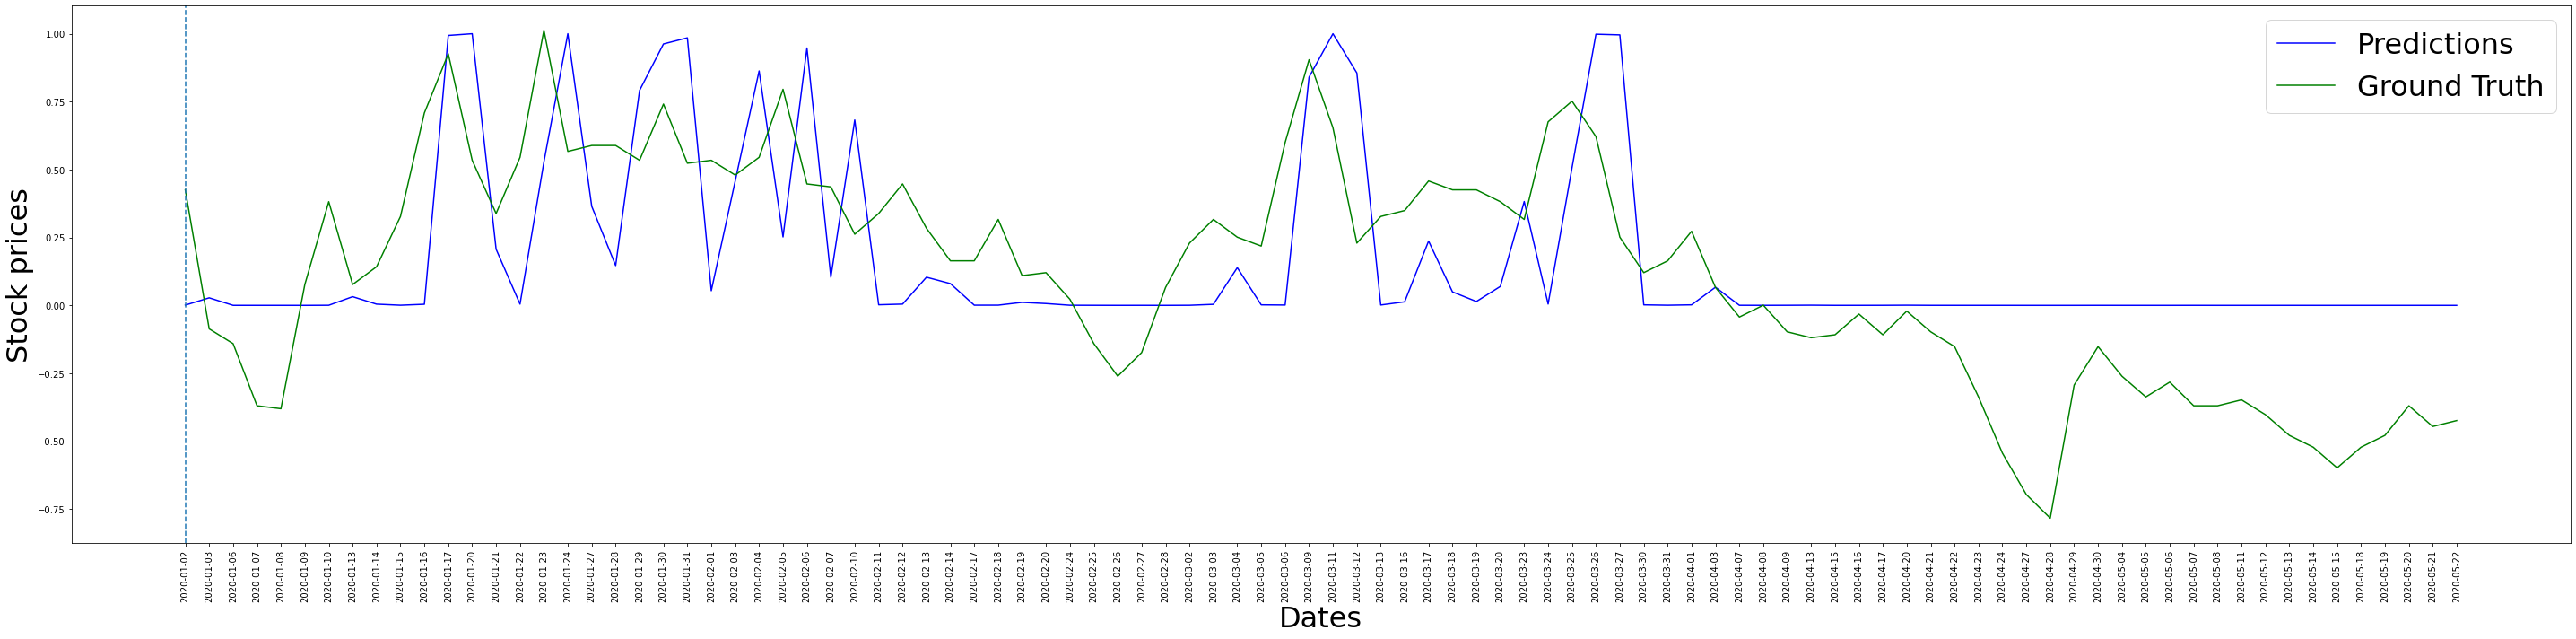

In [19]:
# Format the predictions into a dataframe and save them to a file in the predictions folder
flags = ["valid"] * len(val_labels)

df = pd.DataFrame([(x[0], y[0]) for x, y in zip(val_preds, val_labels)], columns = ["Predictions", "Ground Truth"])
df["Type"] = flags
df.index = dates[:96]
# df.to_csv("pred_pth.csv")

# Find out the first element which belongs to validation dataset to depict the same manually
dt = None
for idx, item in enumerate(df.Type):
    if item == "valid":
        dt = df.index[idx]
        break
    

print(df.shape)
# Create the plot and save it to the path provided as an argument above
fs = 32
plt.figure(figsize = (40,10))
plt.plot(df.index, df["Predictions"], color = "blue")
plt.plot(df.index, df["Ground Truth"], color = "green")
plt.legend(["Predictions", "Ground Truth"], fontsize = fs)
plt.axvline(x = dt, linestyle = "--")
plt.xticks(rotation = 90)
plt.xlabel("Dates", fontsize = fs)
plt.ylabel("Stock prices", fontsize = fs)
plt.tight_layout()
plt.show()

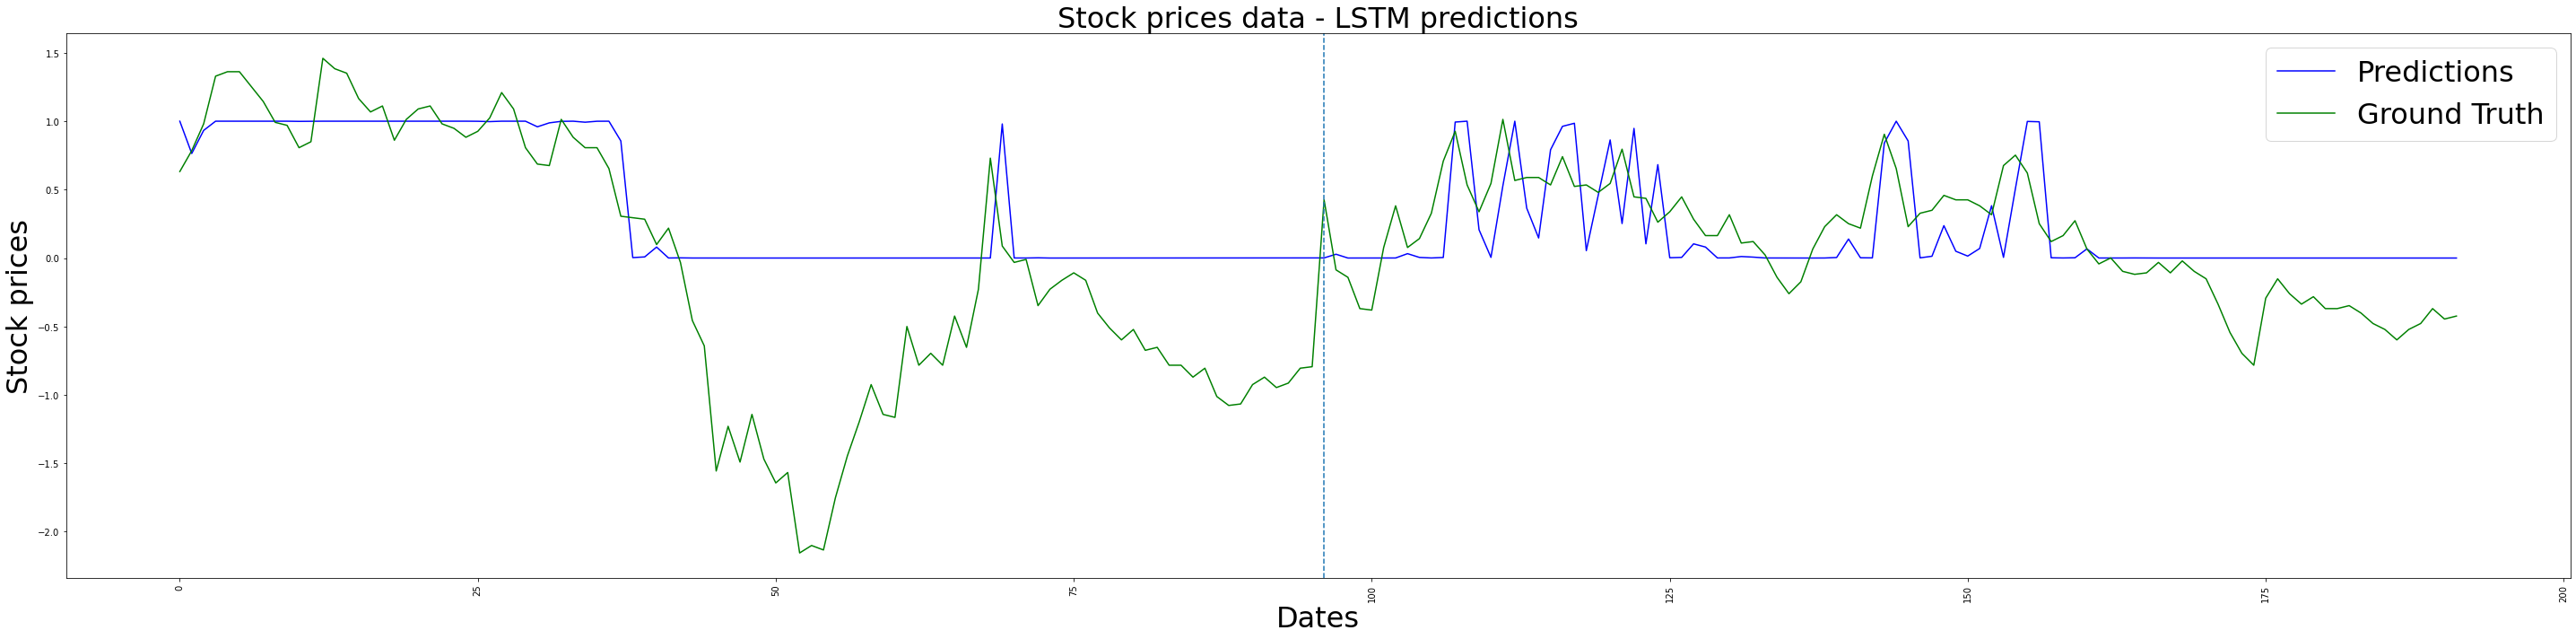

In [38]:
all_preds = np.concatenate((train_preds,val_preds))
all_labels = np.concatenate((train_labels,val_labels))
flags = ["train"] * len(train_labels) + ["valid"] * len(val_labels)

df = pd.DataFrame([(x[0], y[0]) for x, y in zip(all_preds, all_labels)], columns = ["Predictions", "Ground Truth"])
df["Type"] = flags

# Find out the first element which belongs to validation dataset to depict the same manually
dt = None
for idx, item in enumerate(df.Type):
    if item == "valid":
        dt = df.index[idx]
        break
    
    # Create the plot and save it to the path provided as an argument above
fs = 32
plt.figure(figsize = (40,10))
plt.plot(df.index, df["Predictions"], color = "blue")
plt.plot(df.index, df["Ground Truth"], color = "green")
plt.legend(["Predictions", "Ground Truth"], fontsize = fs)
plt.axvline(x = dt, linestyle = "--")
plt.xticks(rotation = 90)
plt.xlabel("Dates", fontsize = fs)
plt.ylabel("Stock prices", fontsize = fs)
plt.title("Stock prices data - LSTM predictions", fontsize = fs)
plt.tight_layout()
plt.show()

# Test on a New DataSet

In [21]:
inputs_test, labels_test, dates_test = curateData("TimeSeriesForecastingNN-main/data/5PAISA.csv", "Close", "Date", 1)

There are no NaN values in the DataFrame.


In [29]:
inputs_test = inputs_test[3:]
labels_test = labels_test[3:]
dates_test = dates_test[3:]

In [30]:
batch_size = 4

params = {"batch_size": batch_size,
         "shuffle": False,
         "num_workers": 0}

In [31]:
# Standardize the data to bring the inputs on a uniform scale
inputs_test, SS_ = standardizeData(inputs_test, train = True)

labels_test = standardizeData(np.array(labels_test).reshape(-1, 1), SS_)[0].flatten()



# Create dataloaders for testing datasets
testing_generator = getDL(inputs_test, labels_test, params)

In [32]:
to_numpy = lambda x, y: (x.squeeze(0).detach().numpy(), y.squeeze(0).numpy())

test_preds, test_labels = get_preds(testing_generator, model)
test_preds, test_labels = to_numpy(test_preds.cpu(), test_labels.cpu())

In [34]:
print(len(test_labels ))

152


In [35]:
print(len(test_preds))

152


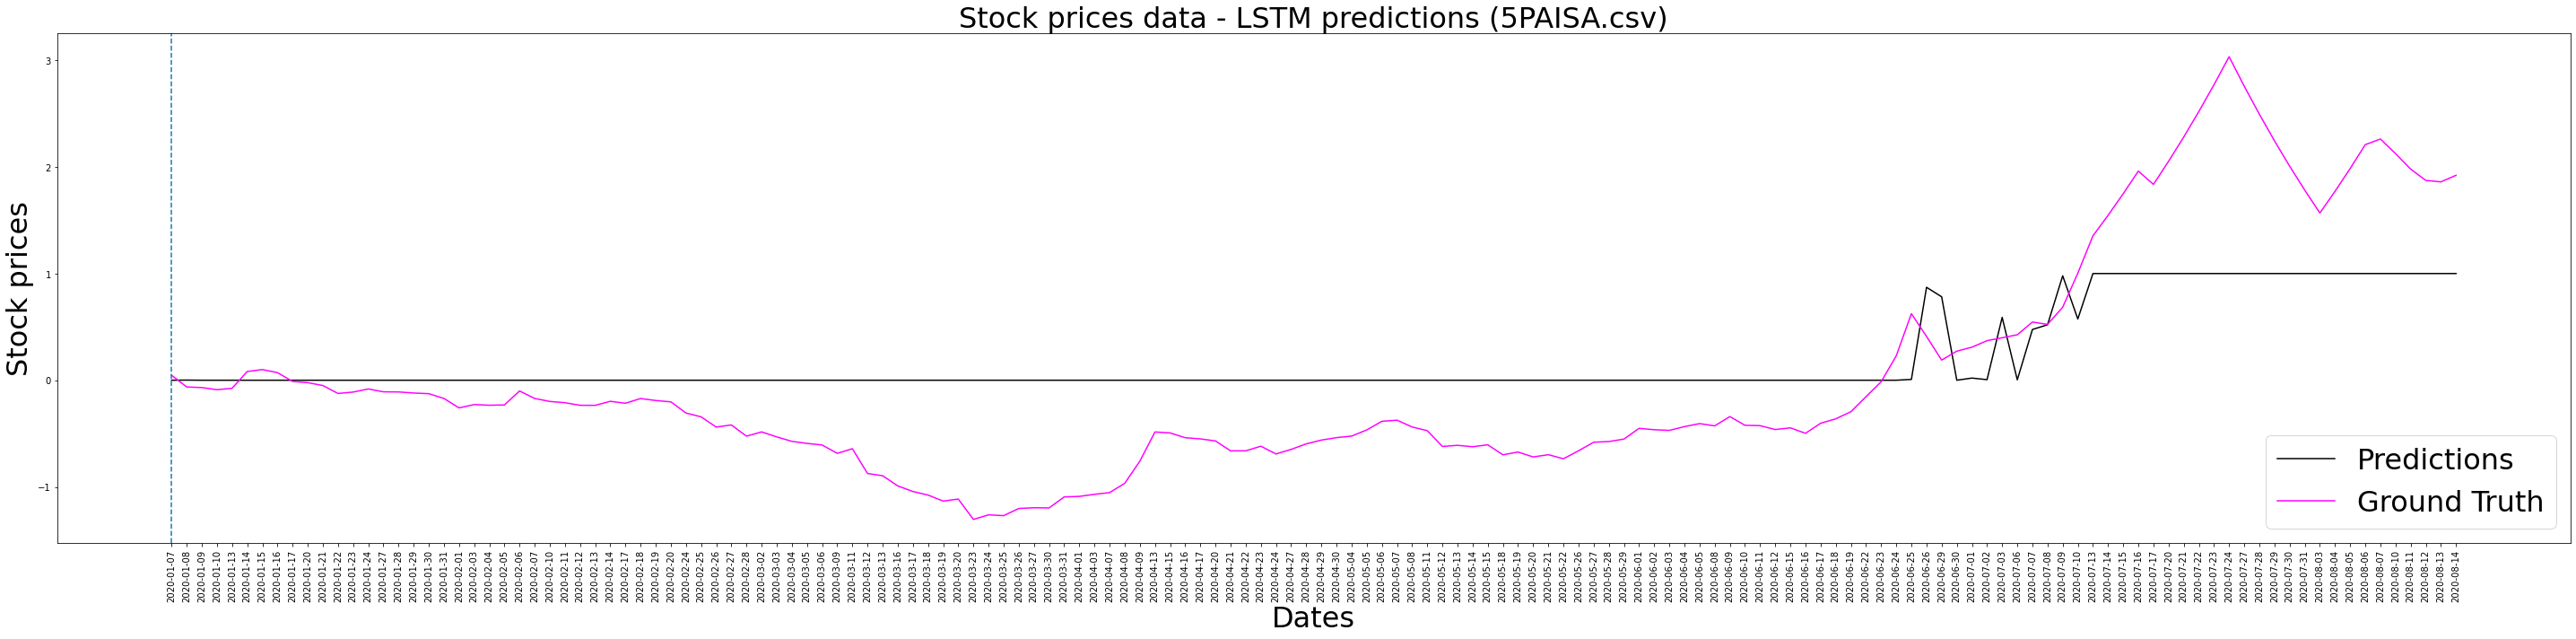

In [38]:
flags = ["test"] * len(test_labels)

df = pd.DataFrame([(x[0], y[0]) for x, y in zip(test_preds, test_labels)], columns = ["Predictions", "Ground Truth"])
df["Type"] = flags
df.index = dates_test

# Find out the first element which belongs to validation dataset to depict the same manually
dt = None
for idx, item in enumerate(df.Type):
    if item == "test":
        dt = df.index[idx]
        break
    
    # Create the plot and save it to the path provided as an argument above
fs = 32
plt.figure(figsize = (40,10))
plt.plot(df.index, df["Predictions"], color = "black")
plt.plot(df.index, df["Ground Truth"], color = "magenta")
plt.legend(["Predictions", "Ground Truth"], fontsize = fs)
plt.axvline(x = dt, linestyle = "--")
plt.xticks(rotation = 90)
plt.xlabel("Dates", fontsize = fs)
plt.ylabel("Stock prices", fontsize = fs)
plt.title("Stock prices data - LSTM predictions (5PAISA.csv)", fontsize = fs)
plt.tight_layout()
plt.show()

In [42]:
par = params = {"batch_size": 1,
         "shuffle": False,
         "num_workers": 0}

In [43]:
testing_generator_rand = getDL(inputs_test, labels_test, par)

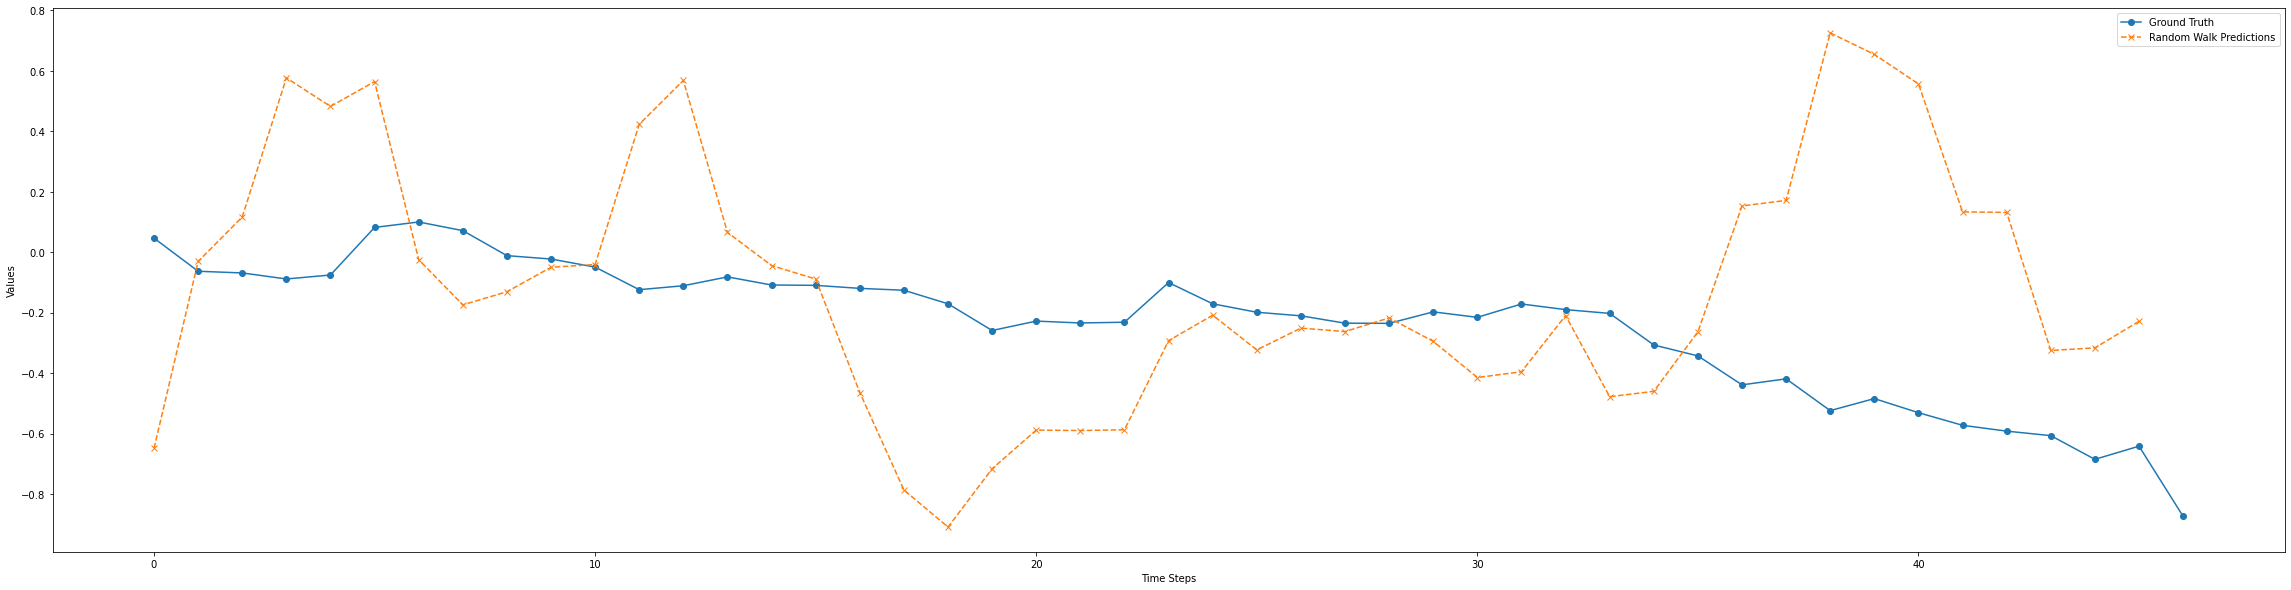

In [61]:
# Random walk parameters
num_steps = 50

# Perform random walk and collect visited data points
visited_data_points = []
for _ in range(num_steps):
    random_batch = random.choice(list(testing_generator_rand))

    visited_data_points.append(random_batch[0].item())

# Calculate predictions using a simple rolling average
window_size = 5
predictions = []
for i in range(len(visited_data_points) - window_size + 1):
    window = visited_data_points[i:i + window_size]
    predictions.append(sum(window) / window_size)

# Prepare ground truth
ground_truth = [batch[1].item() for batch in testing_generator_rand]

# Plot predictions against ground truth
plt.figure(figsize=(40,10))
plt.plot(ground_truth[:47], label='Ground Truth', linestyle='-', marker='o')
plt.plot(predictions, label='Random Walk Predictions', linestyle='--', marker='x')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

In [ ]:
#HYPERPARAMETER TUNNING

params = {
    'lr': [0.001, 0.005, 0.01],#[0.001,0.005, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_epochs': list(range(500,700, 100)),
    "batch_size": [8,16]
}
val_per_param = np.zeros((7,10,3))

for x in (range(len(params["lr"]))):
    for y in (range(len(params["max_epochs"]))):
        for z in tqdm(range(len(params["batch_size"]))):
            params1 = {"batch_size": batch_size,
                        "shuffle": False,
                        "num_workers": 0}

            training_generator = getDL(train_x, train_y, params1)
            validation_generator = getDL(val_x, val_y, params1)

            vocab_size = 1
            output_size = 1
            embedding_dim = params["batch_size"][z]
            hidden_dim = 512
            n_layers = 2

            model = LSTMNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
            device = torch.device("cuda")
            model.to(device)

            lr= params["lr"][x]
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            epochs = params["max_epochs"][y]
            counter = 0
            print_every = 10
            clip = 5
            valid_loss_min = np.Inf 

            for i in range(params["max_epochs"][y]):
                
                for inputs, labels in training_generator:
                    counter += 1
                    #h = tuple([e.data for e in h])
                    h = model.init_hidden(batch_size)
                    

                    inputs = inputs.unsqueeze(1)
                    # print(inputs.shape)
                    inputs = inputs.reshape(1,batch_size,1)
                    
                    inputs, labels = inputs.to(device), labels.to(device)
                    model.zero_grad()
                    
                    output, h = model(inputs, h)
                    
                    loss = criterion(output.squeeze(), labels.squeeze())

                    loss.backward(retain_graph=True)
                    nn.utils.clip_grad_norm_(model.parameters(), clip)
                    optimizer.step()
                    
                    if counter%print_every == 0:
                        val_h = model.init_hidden(batch_size)
                        
                        val_losses = []
                        model.eval()
                        for inp, lab in validation_generator:
                            
                            val_h = model.init_hidden(batch_size)
                            
                            inp = inputs.unsqueeze(1)
                            inp = inputs.reshape(1,batch_size,1)
                    #         val_h = tuple([each.data for each in val_h])
                            
                            inp, lab = inp.to(device), lab.to(device)
                            out, val_h = model(inp, val_h)
                            
                            val_loss = criterion(out.squeeze(), lab.float())
                            val_losses.append(val_loss.item())
                        
                        val_per_param[x,y,z] = val_losses[-1]
                            
                        model.train()
                        # print("Epoch: {}/{}...".format(i+1, epochs),
                        #     "Step: {}...".format(counter),
                        #     "Loss: {:.6f}...".format(loss.item()),
                        #     "Val Loss: {:.6f}".format(np.mean(val_losses)))
                        # if np.mean(val_losses) < valid_loss_min:
                        #     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                        #     valid_loss_min = np.mean(val_losses)

96
96
Spearman correlation: 0.8606039508321589
p-value: 2.285156919969648e-09


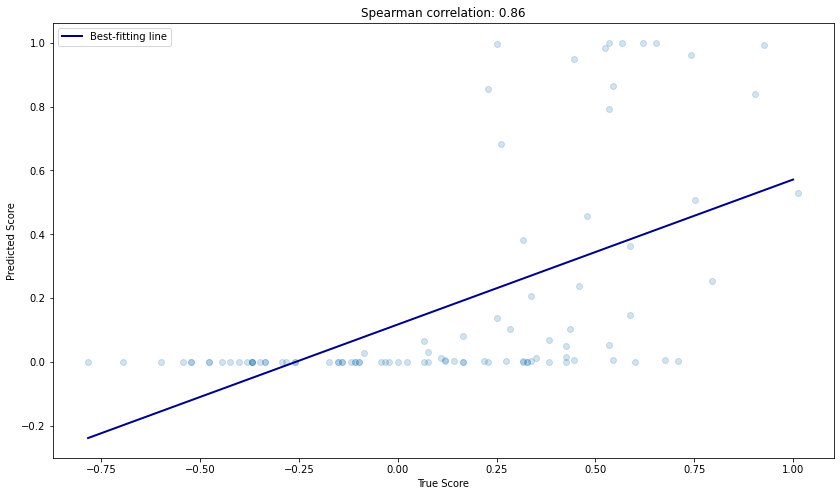

In [21]:
#SPEARMAN
true_score = []
for batch in true:
    for score in batch:
        true_score.append(score.item())
print(len(true_score))

pred_score = []
for batch in pred:
    for score in batch:
        pred_score.append(score.item())
print(len(pred_score))




correlation, p_value = spearmanr(true_score, pred_score)
slope, intercept, r_value, p_value, std_err = linregress(true_score, pred_score)

print("Spearman correlation:", correlation)
print("p-value:", p_value)

plt.figure(figsize=(14, 8)) 
x_values = np.linspace(np.min(true_score), np.max(pred_score), 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color="#00008B", linewidth=2, label='Best-fitting line')

plt.scatter(true_score, pred_score, cmap='viridis', alpha = 0.2)

# Add labels and title
plt.xlabel("True Value")
plt.ylabel("Predicted Values")
plt.title(f"Spearman correlation: {correlation:.2f}")
plt.legend()

# Display the plot
plt.show()

In [33]:
#Directional Symmetry (DS)

def directional_symmetry(y_true, y_pred):
    """
    Calculate the directional symmetry (DS) of two time series.
    
    Args:
    y_true (np.array): The ground truth time series data (labels).
    y_pred (np.array): The predicted time series data.
    
    Returns:
    float: The directional symmetry value.
    """
    if len(y_true) != len(y_pred):
        raise ValueError("Both time series must have the same length.")

    # Calculate the direction of changes for both time series
    true_changes = np.sign(np.diff(y_true))
    pred_changes = np.sign(np.diff(y_pred))

    # Calculate the directional symmetry
    ds = np.sum(true_changes == pred_changes) / (len(y_true) - 1)
    
    return ds

In [34]:
ds = directional_symmetry(true_score, pred_score)

In [35]:
print(ds)

0.47368421052631576
